In [44]:
import os, re, sys, time, json, datetime
import glob
import sent2vec

from os import path

import numpy as np
import pandas as pd

from scipy.spatial import distance
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from string import punctuation

stop_words = set(stopwords.words('english'))



In [8]:
time.perf_counter()

2250340.076879176

In [13]:
zerbe_paper_dict = { 
    "GPCRs": ["32413443", "31754899", "32726501"],
    "LPS": ["30443594", "27166502"],
    "Repeat_Protein": ["30517075", "29480529", "25816772", "24931467"],
    "MT": ["28332759", "31633358", "32196022"],
}

def import_sent2vec_model(trained_model):
  print("Here")
  start = time.perf_counter()
  model = sent2vec.Sent2vecModel()
  try:
      model.load_model(trained_model)
  except Exception as e:
      print(e)
  end = time.perf_counter()
  print(f'model successfully loaded. {end-start:.2f} second used \n'); 

  sentence = preprocess_sentence(
      'If, this sentence, no punctuation, then, \
      the preprocess_sentence function, work good. \
      The correct sentence_vector.shape is (1, 600), now check: \n')
  sentence_vector = model.embed_sentence(sentence)
  print(sentence, sentence_vector.shape)
  return model


def preprocess_sentence(text):
  text = text.replace('/', ' / ')
  text = text.replace('.-', ' .- ')
  text = text.replace('.', ' . ')
  text = text.replace('\'', ' \' ')
  try:
      text = text.lower()
  except:
      text = text.to_string()
      text = text.lower()
  tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]
  return ' '.join(tokens)


def pmid2text(pmid):
    article = fetch.article_by_pmid(pmid)
    try:
        output_text = article.title + article.abstract
    except:
        output_text = article.title
        print("abstract found failed: \n{} \n ".format(output_text))
        

    #print(abstract_dict)
    return output_text


def get_ref_list(pmid, pubmed_list):
    ref_list = []
    pkl_count=0
    for file_name in pubmed_list:
        pkl_count += 1
        df = pd.read_pickle(file_name)
        
        try:
            ref_list = df.loc[pmid, "references"]
            ref_list = ref_list.split(";")
            ref_list = list(set(ref_list).difference(set([""])))
        except:
            continue

        if ref_list != []:
            break
    
    print("for paper id {}, {} pkl file counted, {} reference found". format(pmid, pkl_count, len(ref_list)))
    return ref_list


def get_zerbe_ref(zerbe_paper_dict):
    
    zerbe_ref_dict = {}

    for project in zerbe_paper_dict.keys():

        zerbe_ref_dict[project+"_ref"] = []
        for pmid in zerbe_paper_dict[project]:
            ref_list = get_ref_list(pmid, pubmed_list)

            zerbe_ref_dict[project+"_ref"] = list(
                set(zerbe_ref_dict[project+"_ref"])
                .union(set(ref_list))
                .difference(set([""])))
    
    print(zerbe_ref_dict)
    return zerbe_ref_dict


def paper_list2pmid2vector(paper_list):
    pmid2vector = {}
    
    for pmid in paper_list:
        pmid2vector[pmid] = model.embed_sentence(preprocess_sentence(pmid2text(pmid)))
    
    return pmid2vector


modelfile= "/home/miemie/Downloads/wiki_unigrams.bin"
model = import_sent2vec_model(modelfile); 

# pubmed_list = glob.glob("/Users/wdai/Desktop/Scripts/sent2vec/updatefiles/*_df.pkl")
# pubmed_list.sort(reverse=True)

# """
# zerbe_ref_dict = get_zerbe_ref(zerbe_paper_dict)

# paper_list = [paper for papers in zerbe_paper_dict.values() for paper in papers] \
#             + [paper for papers in zerbe_ref_dict.values() for paper in papers]

# print(paper_list)

# """

# paper_list = ['32413443', '31754899', '32726501', '30443594', '27166502', \
#     '30517075', '29480529', '25816772', '24931467', '28332759', '31633358', \
#     '32196022', '22948827', '27484442', '10410806', '29290469', '26577727', \
#     '26631602', '20157899', '9811843', '25881211', '25419869', '22034093', \
#     '15452431', '23294159', '31165321', '20512150', '15731457', '19548092', \
#     '12362368', '9356455', '28289927', '22180244', '28844743', '6584904', \
#     '16341750', '20161395', '9751724', '15318003', '23435576', '25430058', \
#     '29176642', '29058416', '12188667', '2184895', '9217263', '22752932', \
#     '16593445', '19682887', '20363267', '31034888', '31217444', '25284766', \
#     '16188473', '2257039', '10452895', '24653034', '22794163', '14599227', \
#     '12119389', '30177765', '21501622', '12206785', '31103421', '23415558', \
#     '23164568', '15215534', '27878649', '28691806', '24364740', '21925267', \
#     '18192400', '26566791', '18677733', '6466605', '28167546', '23686103', \
#     '26061769', '7875313', '9760181', '18424520', '16861298', '26627837', \
#     '28886680', '22549735', '25801209', '24794931', '20203010', '19548092', \
#     '20720015', '29449493', '28419595', '27161645', '15318003', '21288828', \
#     '29480529', '28919360', '28852068', '27161977', '24123237', '22109962', \
#     '8577744', '28394325', '28790314', '24990751', '22668317', '12491537', \
#     '18534617', '23138981', '20167788', '27331141', '18480051', '22936569', \
#     '27026255', '20566849', '24990744']

# pmid2vector = paper_list2pmid2vector(paper_list)

# pkl_count = 0
# start = time.time()

# for file_name in pubmed_list:
#     pkl_count += 1
#     df = pd.read_pickle(file_name)
#     df.drop_duplicates(subset=['title'])
#     df = df.loc[~df.index.duplicated(keep='first')]

#     for pmid in df.index.tolist():
#         paper_text = df.loc[pmid, "title"] + df.loc[pmid, "abstract"]
#         if isinstance(paper_text,str) == False:
#             print(paper_text)
#             paper_text =str(paper_text)

#         sentence_vector1 = model.embed_sentence(preprocess_sentence(paper_text))

#         for ref_pmid, sentence_vector2 in pmid2vector.items():

#             cosine_sim = 1 - distance.cosine(sentence_vector1, sentence_vector2)
#             df.loc[pmid, ref_pmid+"_score"] = cosine_sim

    
#     df.to_pickle(file_name)
#     print("pkl_count is {} of 1257".format(pkl_count), end='\r')

# end = time.time()


# print("finially!!! all pkl updateded. The updating process take {} hours."
#         .format(round((end-start)/3600, 2)))

Here
model successfully loaded. 27.67 second used 

sentence punctuation preprocess_sentence function work good correct sentence_vector shape 1 700 check (1, 600)


In [12]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/miemie/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

0.9973659127013625
[[-3.18896965  0.31866398]
 [-2.12361686 -0.21181183]
 [-1.13384957 -1.40705672]
 [ 0.05146887  1.45118009]
 [ 1.09522185  0.54158247]
 [ 2.09936949 -0.47194488]
 [ 3.20037586 -0.22061312]]


/home/miemie/miniconda3/envs/sentvec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/miemie/miniconda3/envs/sentvec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


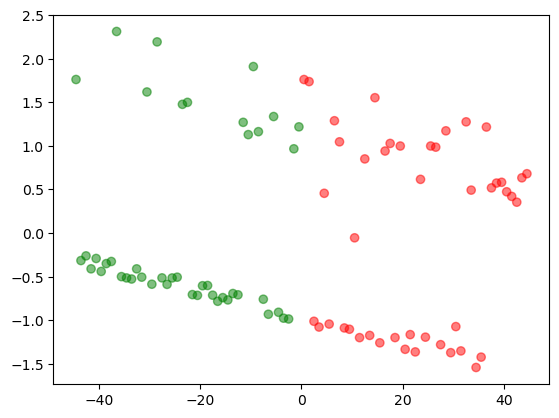

In [43]:
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

# listseq=[[j for j in i] for i in listseq]

listseq=[[idx,[j for j in i]] for idx,i in enumerate(listseq)]

listseq = pd.DataFrame(listseq, columns=['id', 'sequence'])


# listseq = np.array(listseq)
from sgt import SGT

def embed(seqs):
  listseq=[[idx,[j for j in i]] for idx,i in enumerate(seqs)]; 
  listseq = pd.DataFrame(listseq, columns=['id', 'sequence']); 
  sgt = SGT(kappa = 10, lengthsensitive = False, flatten=True); 
  embedding = sgt.fit_transform(listseq); 
  return embedding
  
# print(listseq)
# print(embedding, embedding.shape)

pca = PCA(n_components=2)

pca.fit(embedding)

df = pca.transform(embedding)
df = pd.DataFrame(df, columns=["x1", "x2"])
print(np.sum(pca.explained_variance_ratio_))
print(X)



kmeans = KMeans(n_clusters=2, max_iter = 100)
kmeans.fit(df)
# hc = AgglomerativeClustering(n_clusters=2)
# df = hc.fit_predict(df.T);

labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_
# fig = plt.figure(figsize=(5, 5))
colmap = {1: 'r', 2: 'g', 3: 'b'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df['x1'], df['x2'], color=colors, alpha=0.5, edgecolor=colors)



In [19]:
import pandas as pd
# A sample corpus of two sequences.
corpus = pd.DataFrame([[1, ["B","B","A","C","A","C","A","A","B","A"]], 
                       [2, ["C", "Z", "Z", "Z", "D"]]], 
                      columns=['id', 'sequence'])
print(corpus)
sgt = SGT(kappa=1, 
          flatten=True, 
          lengthsensitive=False, 
          mode='default')
sgt.fit_transform(corpus)

   id                        sequence
0   1  [B, B, A, C, A, C, A, A, B, A]
1   2                 [C, Z, Z, Z, D]


,id,"(A, A)","(A, B)","(A, C)","(A, D)","(A, Z)","(B, A)","(B, B)","(B, C)","(B, D)",...,"(D, A)","(D, B)","(D, C)","(D, D)","(D, Z)","(Z, A)","(Z, B)","(Z, C)","(Z, D)","(Z, Z)"
0,1.0,0.090616,0.131002,0.261849,0.0,0.0,0.086569,0.123042,0.052544,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.184334,0.290365
